# Units Added by Year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sqlalchemy import create_engine
from pysandag.database import get_connection_string

%matplotlib inline

db_connection_string = get_connection_string('..\data\config.yml', 'mssql_db')
mssql_engine = create_engine(db_connection_string)

Get max run id from urbansim

In [2]:
run_id_sql = '''
SELECT max(run_id)
  FROM [urbansim].[urbansim].[urbansim_lite_output]
'''
run_id_df = pd.read_sql(run_id_sql, mssql_engine)
run_id = int(run_id_df.values)
print("\nMax run id : {:,}\n".format(run_id))


Max run id : 3



# Regionwide totals from simulation

Regionwide forecast

In [3]:
housing_unit_sql = '''select  yr,
    housing_units1, households,housing_units_add 
    from [isam].[economic_output].[urbansim_housing_units]'''
hu_df =  pd.read_sql(housing_unit_sql, mssql_engine,index_col ='yr')
hu_df['total_housing_units_add'] = hu_df.housing_units_add.cumsum()
hu_df.rename(columns = {'housing_units_add': 'Housing units to add'}, inplace=True)
hu_df_to_plot = hu_df[['Housing units to add']].copy()
print("\nTarget: {:,}\n".format(int(hu_df_to_plot['Housing units to add'].sum())))


Target: 396,354



Urbansim

In [4]:
hs_change_by_yr_sql = '''
    SELECT source, sum(units_added) as housing_units_added,year_simulation
      FROM urbansim.urbansim.urbansim_lite_output o 
      JOIN urbansim.urbansim.parcel p on p.parcel_id = o.parcel_id
      JOIN urbansim.ref.jurisdiction j on p.jurisdiction_id = j.jurisdiction_id
     WHERE run_id =  %s
     GROUP BY source,year_simulation'''

hs_change_by_yr_sql = hs_change_by_yr_sql % run_id
units_added_by_yr_and_source = pd.read_sql(hs_change_by_yr_sql,mssql_engine)

units_by_yr = pd.DataFrame({'housing_units_added': units_added_by_yr_and_source.
                                            groupby(["year_simulation"]).
                                 housing_units_added.sum()}).reset_index()
units_by_yr.rename(columns = {'housing_units_added': 'Housing units added'}, inplace=True)
units_by_yr.set_index('year_simulation',inplace=True)
print("\nUnits added: {:,}\n".format(int(units_by_yr['Housing units added'].sum())))


Units added: 364,170



Deficit

In [8]:
diff = int(hu_df_to_plot['Housing units to add'].sum()) - int(units_by_yr['Housing units added'].sum())
print("\nDeficit: {:,}\n".format(diff))


Deficit: 32,184



pivot to get housing units by source

In [6]:
units_added_by_source = units_added_by_yr_and_source.pivot\
(index='year_simulation', columns='source', values='housing_units_added')
units_added_by_source.rename(columns = {'sched_dev': 'scheduled development'}, inplace=True)
units_added_by_source.rename(columns = {'subregional_control': 'control percentages'}, inplace=True)
units_added_by_source.rename(columns = {'entire_region': 'remaining'}, inplace=True)
subregional_control = units_added_by_source['control percentages'].sum()
print("\nUnits added from subregional control percentages: {:,}".format(int(subregional_control)))
sched_dev = units_added_by_source['scheduled development'].sum()
print("\nUnits added from scheduled developments: {:,}".format(int(sched_dev)))
entire_region = units_added_by_source['remaining'].sum()
print("\nUnits added from remaining: {:,}".format(int(entire_region)))


Units added from subregional control percentages: 249,570

Units added from scheduled developments: 82,352

Units added from remaining: 32,248


plot housing units needed and added by simulation

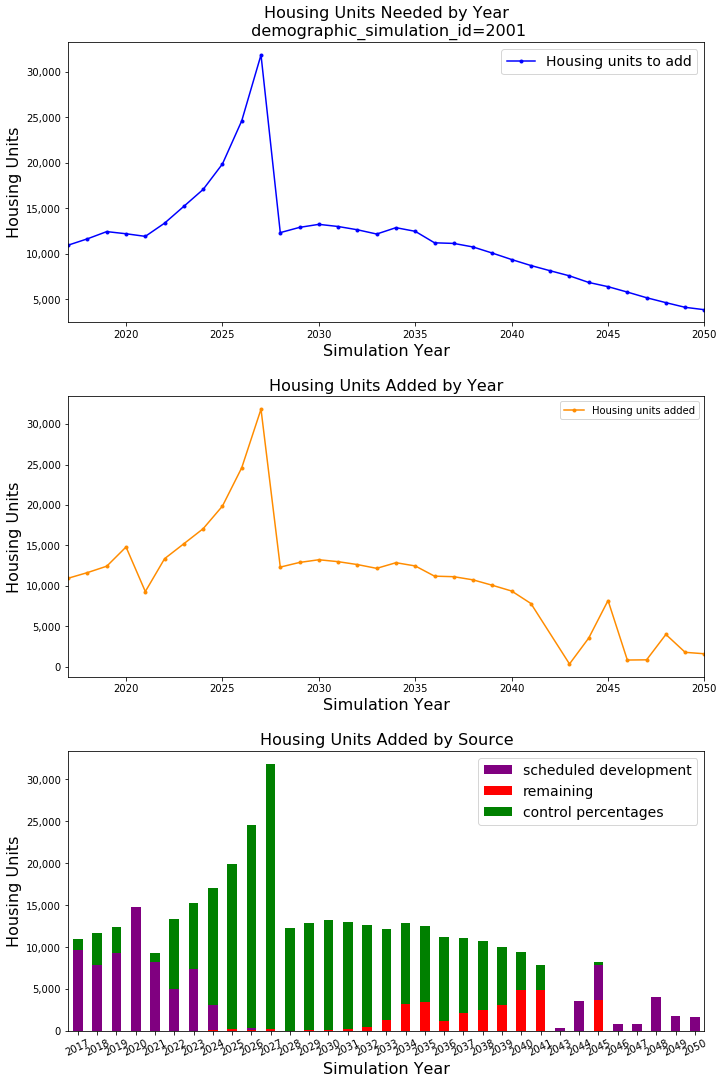

In [7]:
fig, axes = plt.subplots(3, 1)
hu_df_to_plot.plot(style='.-',ax=axes.flat[0],figsize=(10,15),color='b')
units_by_yr.plot(style='.-',ax=axes.flat[1],figsize=(10,15),color=['darkorange','b'])
units_added_by_source.plot(style='.-',stacked=True,kind='bar',ax=axes.flat[2],figsize=(10,15),color=['red','purple','green'])
# units_added_by_source.plot(stacked=True,kind='bar');
# format
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
handles, labels = axes.flat[2].get_legend_handles_labels()
zipped = zip(labels,handles)
zipped.sort(key = lambda t: t[0],reverse=True)
labels, handles = zip(*zipped)


axes.flat[0].set_xlabel("Simulation Year",size =16)
axes.flat[0].set_ylabel("Housing Units",size =16)
axes.flat[0].set_title('Housing Units Needed by Year\n demographic_simulation_id=2001',size=16) 
axes.flat[0].yaxis.set_major_formatter(tick) 
axes.flat[0].legend(fontsize=14)
axes.flat[1].set_xlabel("Simulation Year",size =16)
axes.flat[1].set_ylabel("Housing Units",size =16)
axes.flat[1].set_title('Housing Units Added by Year',size=16) 
axes.flat[1].yaxis.set_major_formatter(tick) 
axes.flat[2].legend(fontsize=14)
axes.flat[2].set_xlabel("Simulation Year",size =16)
axes.flat[2].set_ylabel("Housing Units",size =16)
axes.flat[2].set_title('Housing Units Added by Source',size=16) 
axes.flat[2].yaxis.set_major_formatter(tick) 
axes.flat[2].legend(handles, labels,fontsize=14)
# format
plt.xticks(rotation=25)
plt.tight_layout(pad=0.5, w_pad=0.6, h_pad=2)
plt.show()